In [1]:
library(SoupX)
library(Seurat)
library(patchwork)
library(sctransform)
library(ggplot2)
library(dplyr)
library(hdf5r)
library(DropletUtils)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMin

In [2]:
sessionInfo()

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 9.2 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /tscc/nfs/home/ssharvey/miniconda3/envs/r4-base/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] DropletUtils_1.20.0         SingleCellExperiment_1.22.0
 [3] SummarizedExperiment_1.30.2 Biobase_2.60.0             
 [5] GenomicRanges_1.52.0        GenomeInfoDb_1.36.1        


In [183]:
filt.matrix <- Read10X_h5("~/scratch_2.0_new/fat7_snRNAseq/D6_fastqs_120523/Elovl7_cKO_saline_2/Elovl7_cKO_saline_2/outs/filtered_feature_bc_matrix.h5")
raw.matrix  <- Read10X_h5("~/scratch_2.0_new/fat7_snRNAseq/D6_fastqs_120523/Elovl7_cKO_saline_2/Elovl7_cKO_saline_2/outs/raw_feature_bc_matrix.h5")

In [184]:
#create seurat object from the sparce matrix
srat  <- CreateSeuratObject(counts = filt.matrix)
srat

An object of class Seurat 
32285 features across 9365 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)
 1 layer present: counts

In [185]:
#create SoupChannel
soup.channel  <- SoupChannel(raw.matrix, filt.matrix)
soup.channel

Channel with 32285 genes and 9365 cells



In [186]:
#perform clustering to better perform SoupX
srat    <- SCTransform(srat, verbose = F)
srat    <- RunPCA(srat, verbose = F)

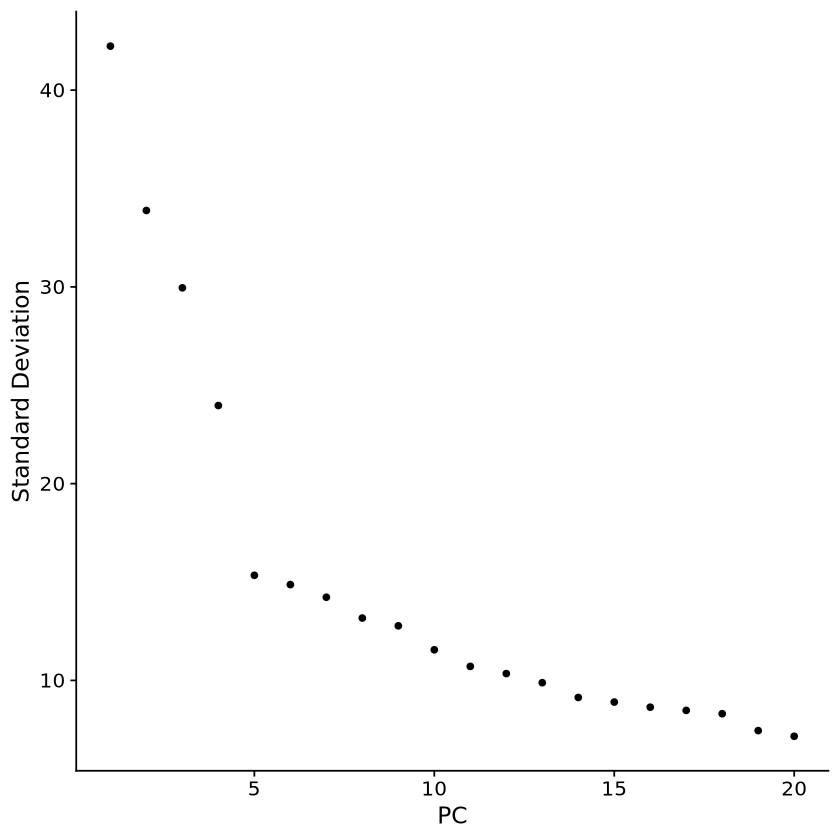

In [187]:
ElbowPlot(srat)

In [188]:
srat    <- RunUMAP(srat, dims = 1:30, verbose = F)
srat    <- FindNeighbors(srat, dims = 1:30, verbose = F)
srat    <- FindClusters(srat, verbose = T)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9365
Number of edges: 307376

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9264
Number of communities: 28
Elapsed time: 0 seconds


In [189]:
#After clustering is obtained, it can be added to the channel using setClusters. setDR is useful for visualizations.
meta    <- srat@meta.data
umap    <- srat@reductions$umap@cell.embeddings
soup.channel  <- setClusters(soup.channel, setNames(meta$seurat_clusters, rownames(meta)))
soup.channel  <- setDR(soup.channel, umap)
head(meta)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>
AAACCCAAGGGCAATC-1,SeuratProject,17566,4525,9031,3674,10,10
AAACCCACAGCTCATA-1,SeuratProject,3143,1529,6956,1854,3,3
AAACCCAGTACCTGTA-1,SeuratProject,922,507,5322,1956,7,7
AAACCCAGTCAATGGG-1,SeuratProject,14826,4135,8949,3798,2,2
AAACCCAGTCGAACGA-1,SeuratProject,4007,1745,7258,1868,3,3
AAACCCATCCGAACGC-1,SeuratProject,1764,1005,6341,1820,5,5


In [190]:
soup.channel

Channel with 32285 genes and 9365 cells



1514 genes passed tf-idf cut-off and 133 soup quantile filter.  Taking the top 100.

Using 1229 independent estimates of rho.

Estimated global rho of 0.02



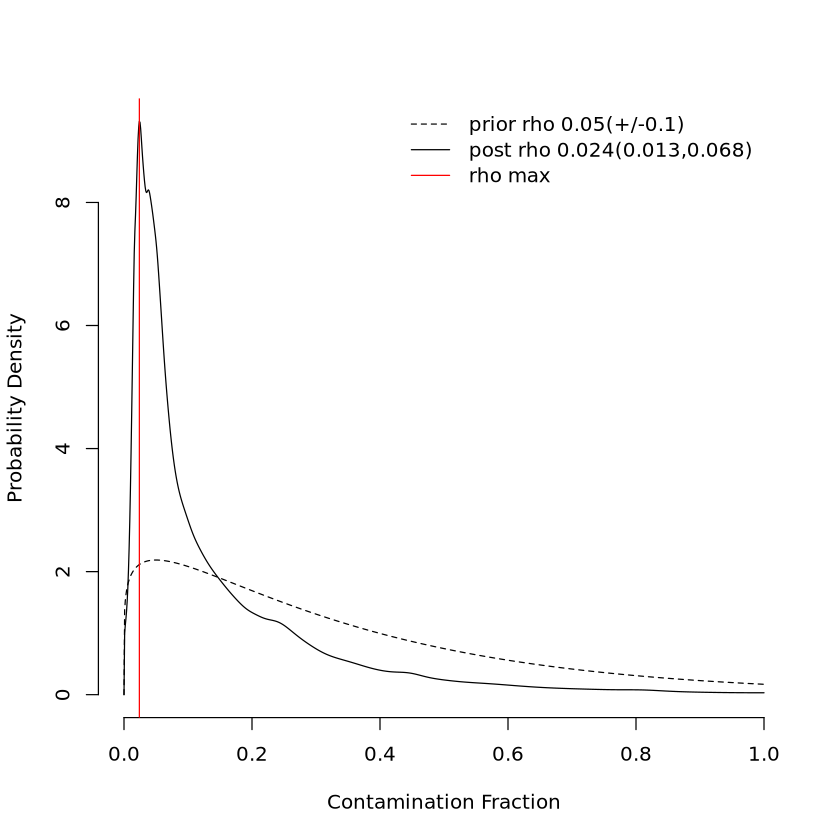

In [191]:
#calculate the automated ambient mRNA profile
soup.channel  <- autoEstCont(soup.channel)

In [192]:
head(soup.channel$soupProfile[order(soup.channel$soupProfile$est, decreasing = T), ], n = 20)

,est,counts
,<dbl>,<dbl>
Malat1,0.060343363,161637
Ptprd,0.005678295,15210
Gm42418,0.005412486,14498
Kcnip4,0.005191851,13907
Meg3,0.004871910,13050
Dpp10,0.004247335,11377
Celf2,0.004121897,11041
Nrxn3,0.003834062,10270
Dlg2,0.003791876,10157


In [193]:
adj.matrix  <- adjustCounts(soup.channel, roundToInt = T)

Warning message in sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w], :
“'giveCsparse' is deprecated; setting repr="T" for you”
Expanding counts from 28 clusters to 9365 cells.



In [194]:
#export SoupX filtered sparse matrix
DropletUtils:::write10xCounts("D6_cKO_saline_2", adj.matrix)